<a href="https://colab.research.google.com/github/Bpriya2001/DeepLearning/blob/main/pytorch_example_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Standard Workflow

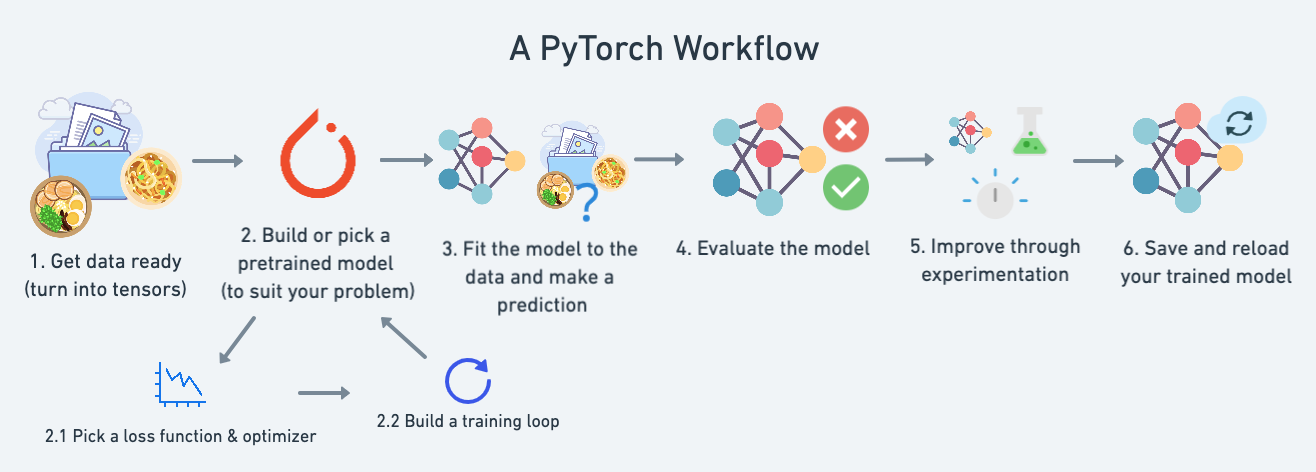

**Import Necessary Libraries**

In [66]:
import torch
from torch import nn
import matplotlib.pyplot as plt

**Data Preparing and Loading**

Let's prepare and load some random data to go through the workflow.

We'll use **linear regression** to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using ***gradient descent***.

In [67]:
weight = 0.7
bias = 0.3

# Create Data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

**Split data into training and test data**

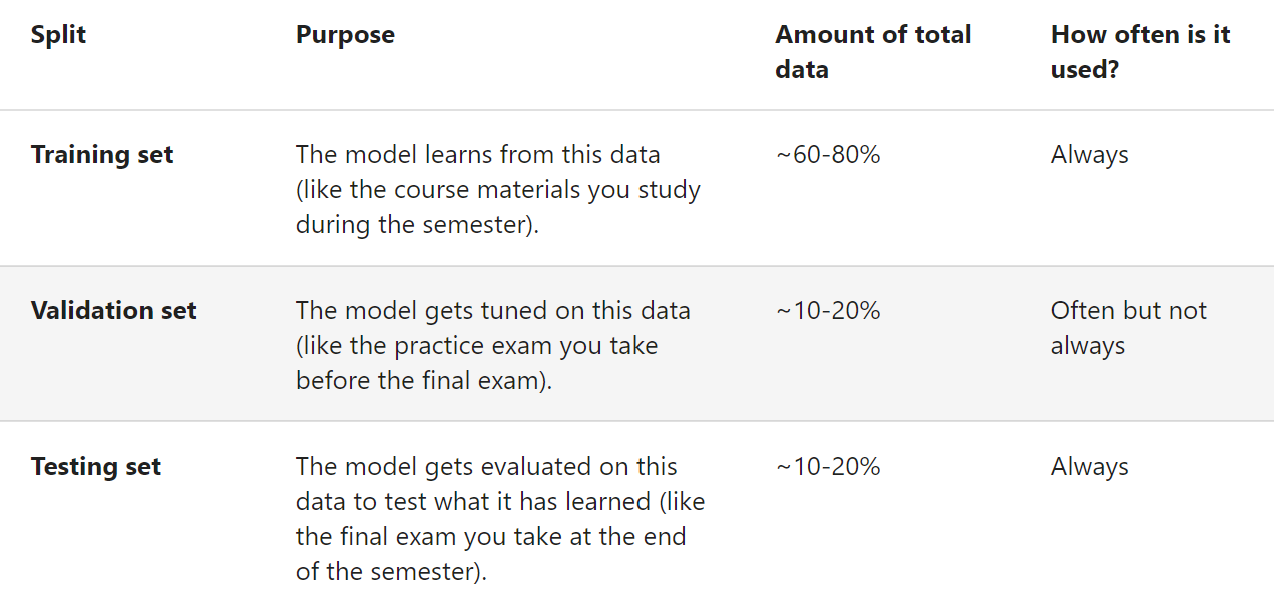


In [68]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([40, 1]) torch.Size([40, 1])
torch.Size([10, 1]) torch.Size([10, 1])


In [69]:
# Lets create a function to visualise this

def plot_prediction(train_data = X_train, train_labels = y_train, test_data = X_test,
                    test_labels = y_test, predictions = None):

  plt.figure(figsize=(10, 5))

  plt.scatter(train_data, train_labels, c='b', label='Training data')
  plt.scatter(test_data, test_labels, c='g', label='Testing data')

  if predictions is not None:
    plt.scatter(test_data, predictions, c = 'r', label='Predictions')

  plt.legend()
  plt.xlabel('Data')
  plt.ylabel('Target')
  plt.title('Training and Testing Data')
  plt.show()

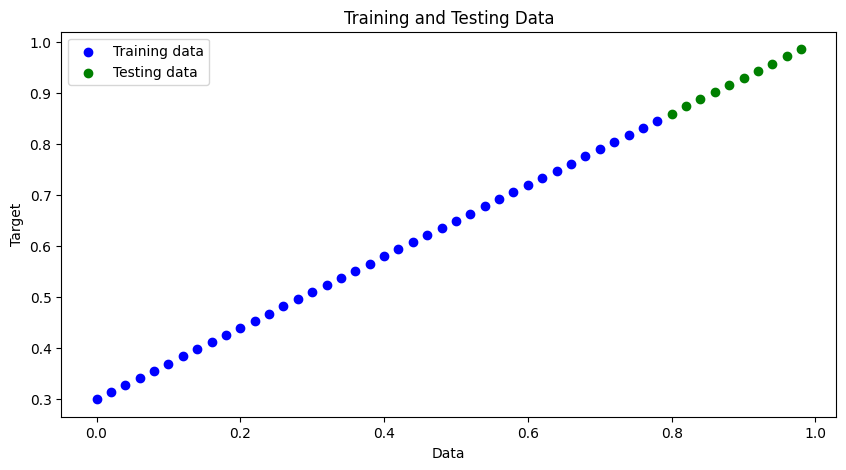

In [70]:
plot_prediction()

Pytorch Building Model

We are doing this by subclassing nn.Module.

What we are trying to do?

* Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
* Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
* Once you've constructed the model, make an instance of it and check its state_dict().

Pytorch has 4 modules that can help us build any model - [torch.nn](https://pytorch.org/docs/stable/nn.html), [torch.optim](https://pytorch.org/docs/stable/optim.html), [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html).

1. nn.Module contains the larger building blocks (layers)
2. nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
3. forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
4. torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

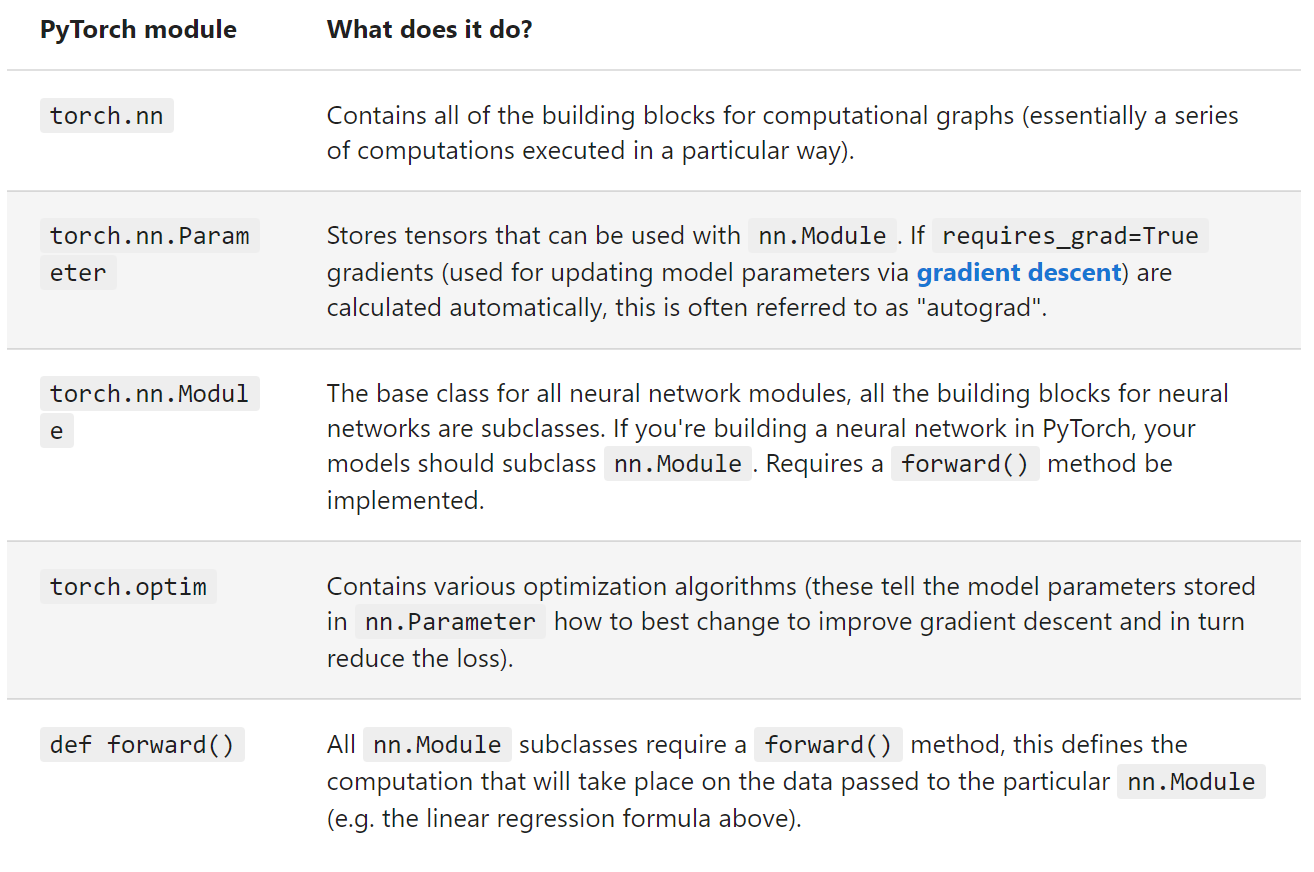


In [71]:
class LinearRegressionModel(nn.Module):

  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [72]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [73]:
# get the state or info about what the model contains

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#  Make predictions using torch.inference_mode()

We use the torch.inference_mode() as a context manager

***Context managers*** in Python allow you to write cleaner code when working with resources. They provide a concise syntax to set up and tear down resources through: An enter logic that gets called when the execution enters the context and. An exit logic the gets called when the execution exits the context.

This is done because the torch.inference_mode turns off a bunch of things to make forward passes faster. It turns of graduent tracking which is required for training but not or inference.

In [74]:
with torch.inference_mode():
  y_preds = model_0(X_test)

print(f"number of testing samples: {len(X_test)}")
print(f"number of predictions: {len(y_preds)}")
print(f"prediction values: {y_preds}")


number of testing samples: 10
number of predictions: 10
prediction values: tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


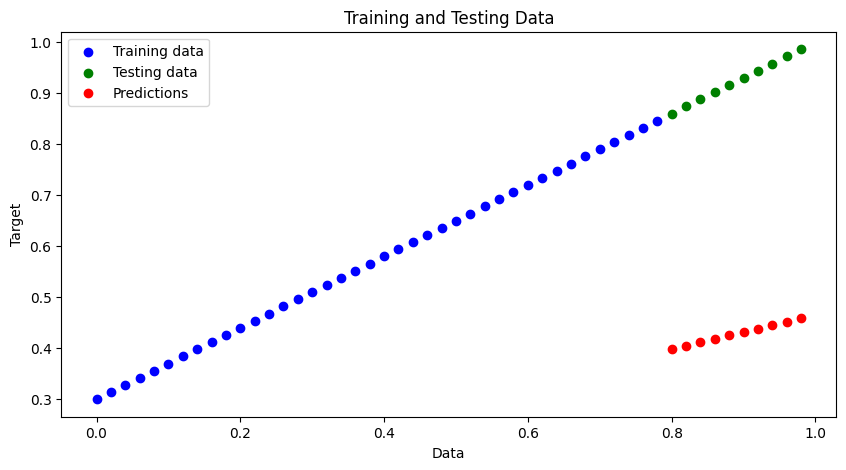

In [75]:
plot_prediction(predictions=y_preds)

In [76]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

This model is really bad. Ideally we want the red and green dots to align. This is because we have chosen random parameters. We can also initialise the model to take in 0 instead of random values.

# Training Model

The whole idea of training is or the model to move from unknown parameters to known parameters.

One way to determine how bad or poor the model representations are is by using loss functions (aka - criterion / cost function)

What do we need for training ?

* **Loss Function**: A function that measures how wrong the predictions are to the actual values.

* **Optimizer**:  Takes the loss function into account to adjust the model's parameters to imporve the loss function. [Pytorch optimizers](https://pytorch.org/docs/stable/optim.html)

L1 and MSE loss for regression
Cross entropy for classification



In [77]:
# Set up Loss function

loss_fn = nn.L1Loss()

# Setup Optimizer (Stochastic Gradient Descent - takes learning rate and parameters)
# parameters -> what does the optimizer need to optimmise ?
# learning rate -> learning rate (how much the optimizer should change parameters at each step,
# higher=more (less stable), lower=less (might take a long time)

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

# Building a Training Loop

Training loop involves the model going through the training data and learning relationships between features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

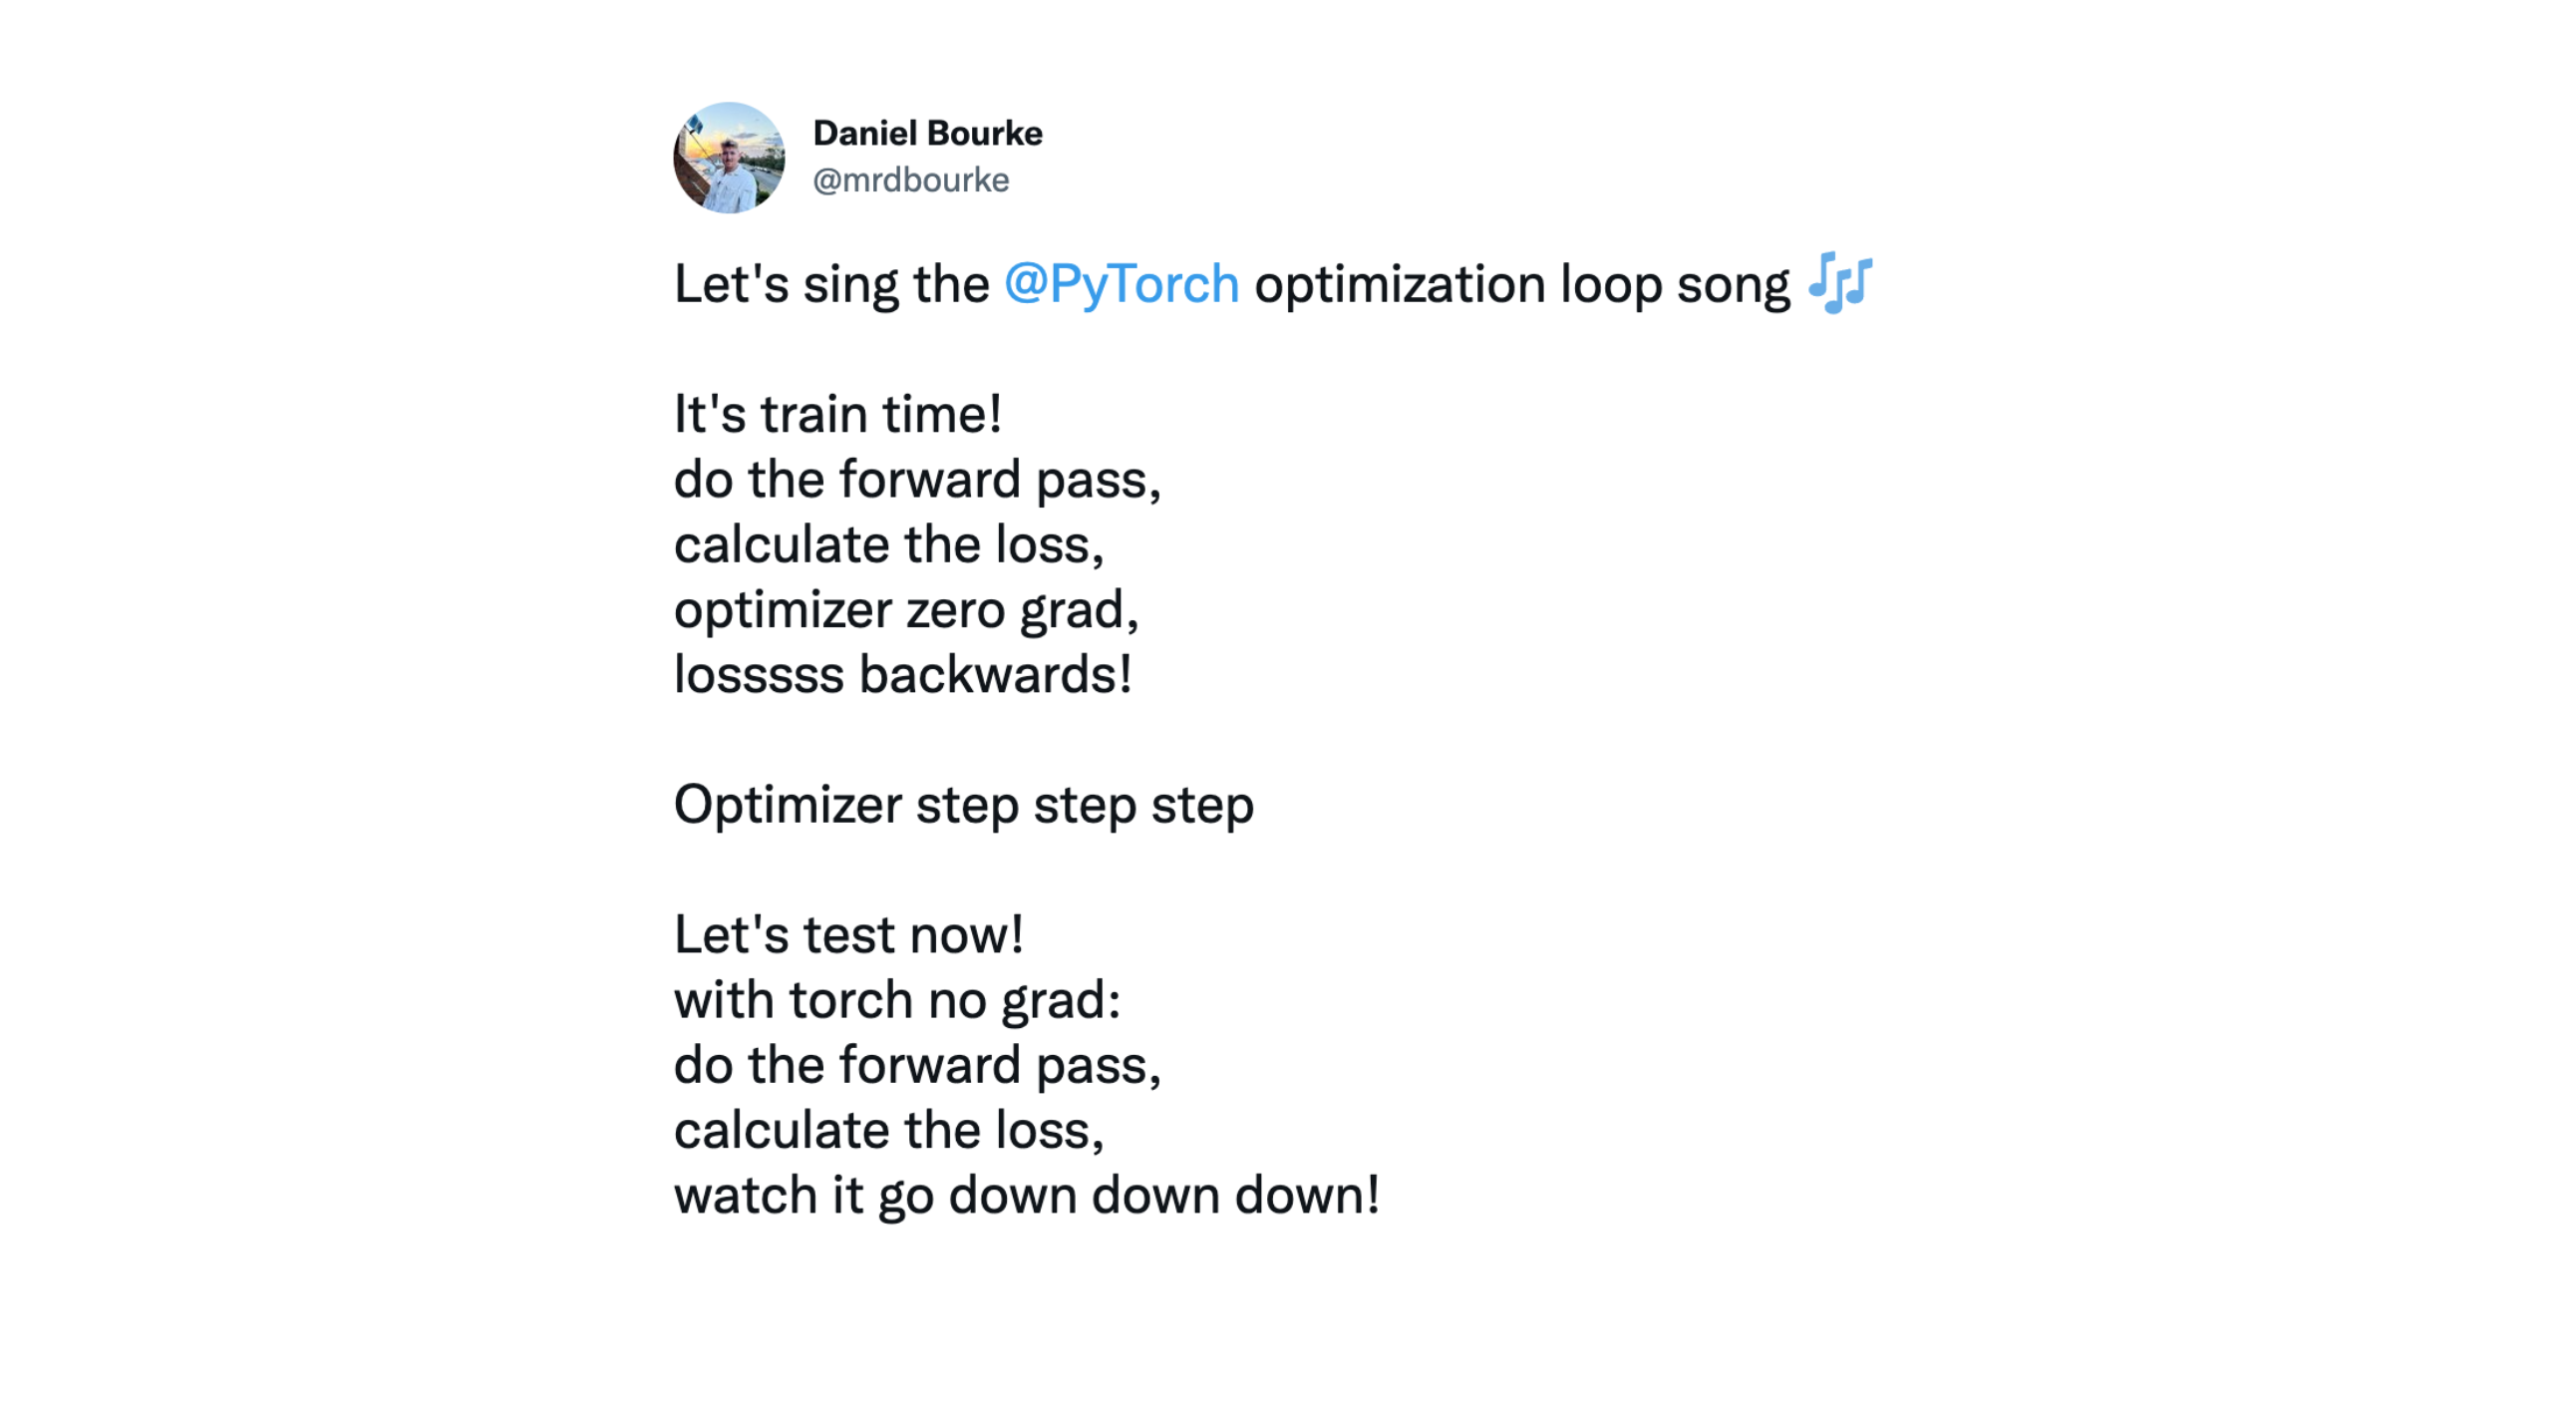

[There's a song to help you remeber, annoying but helpful lol](https://www.youtube.com/watch?v=Nutpusq_AFw)


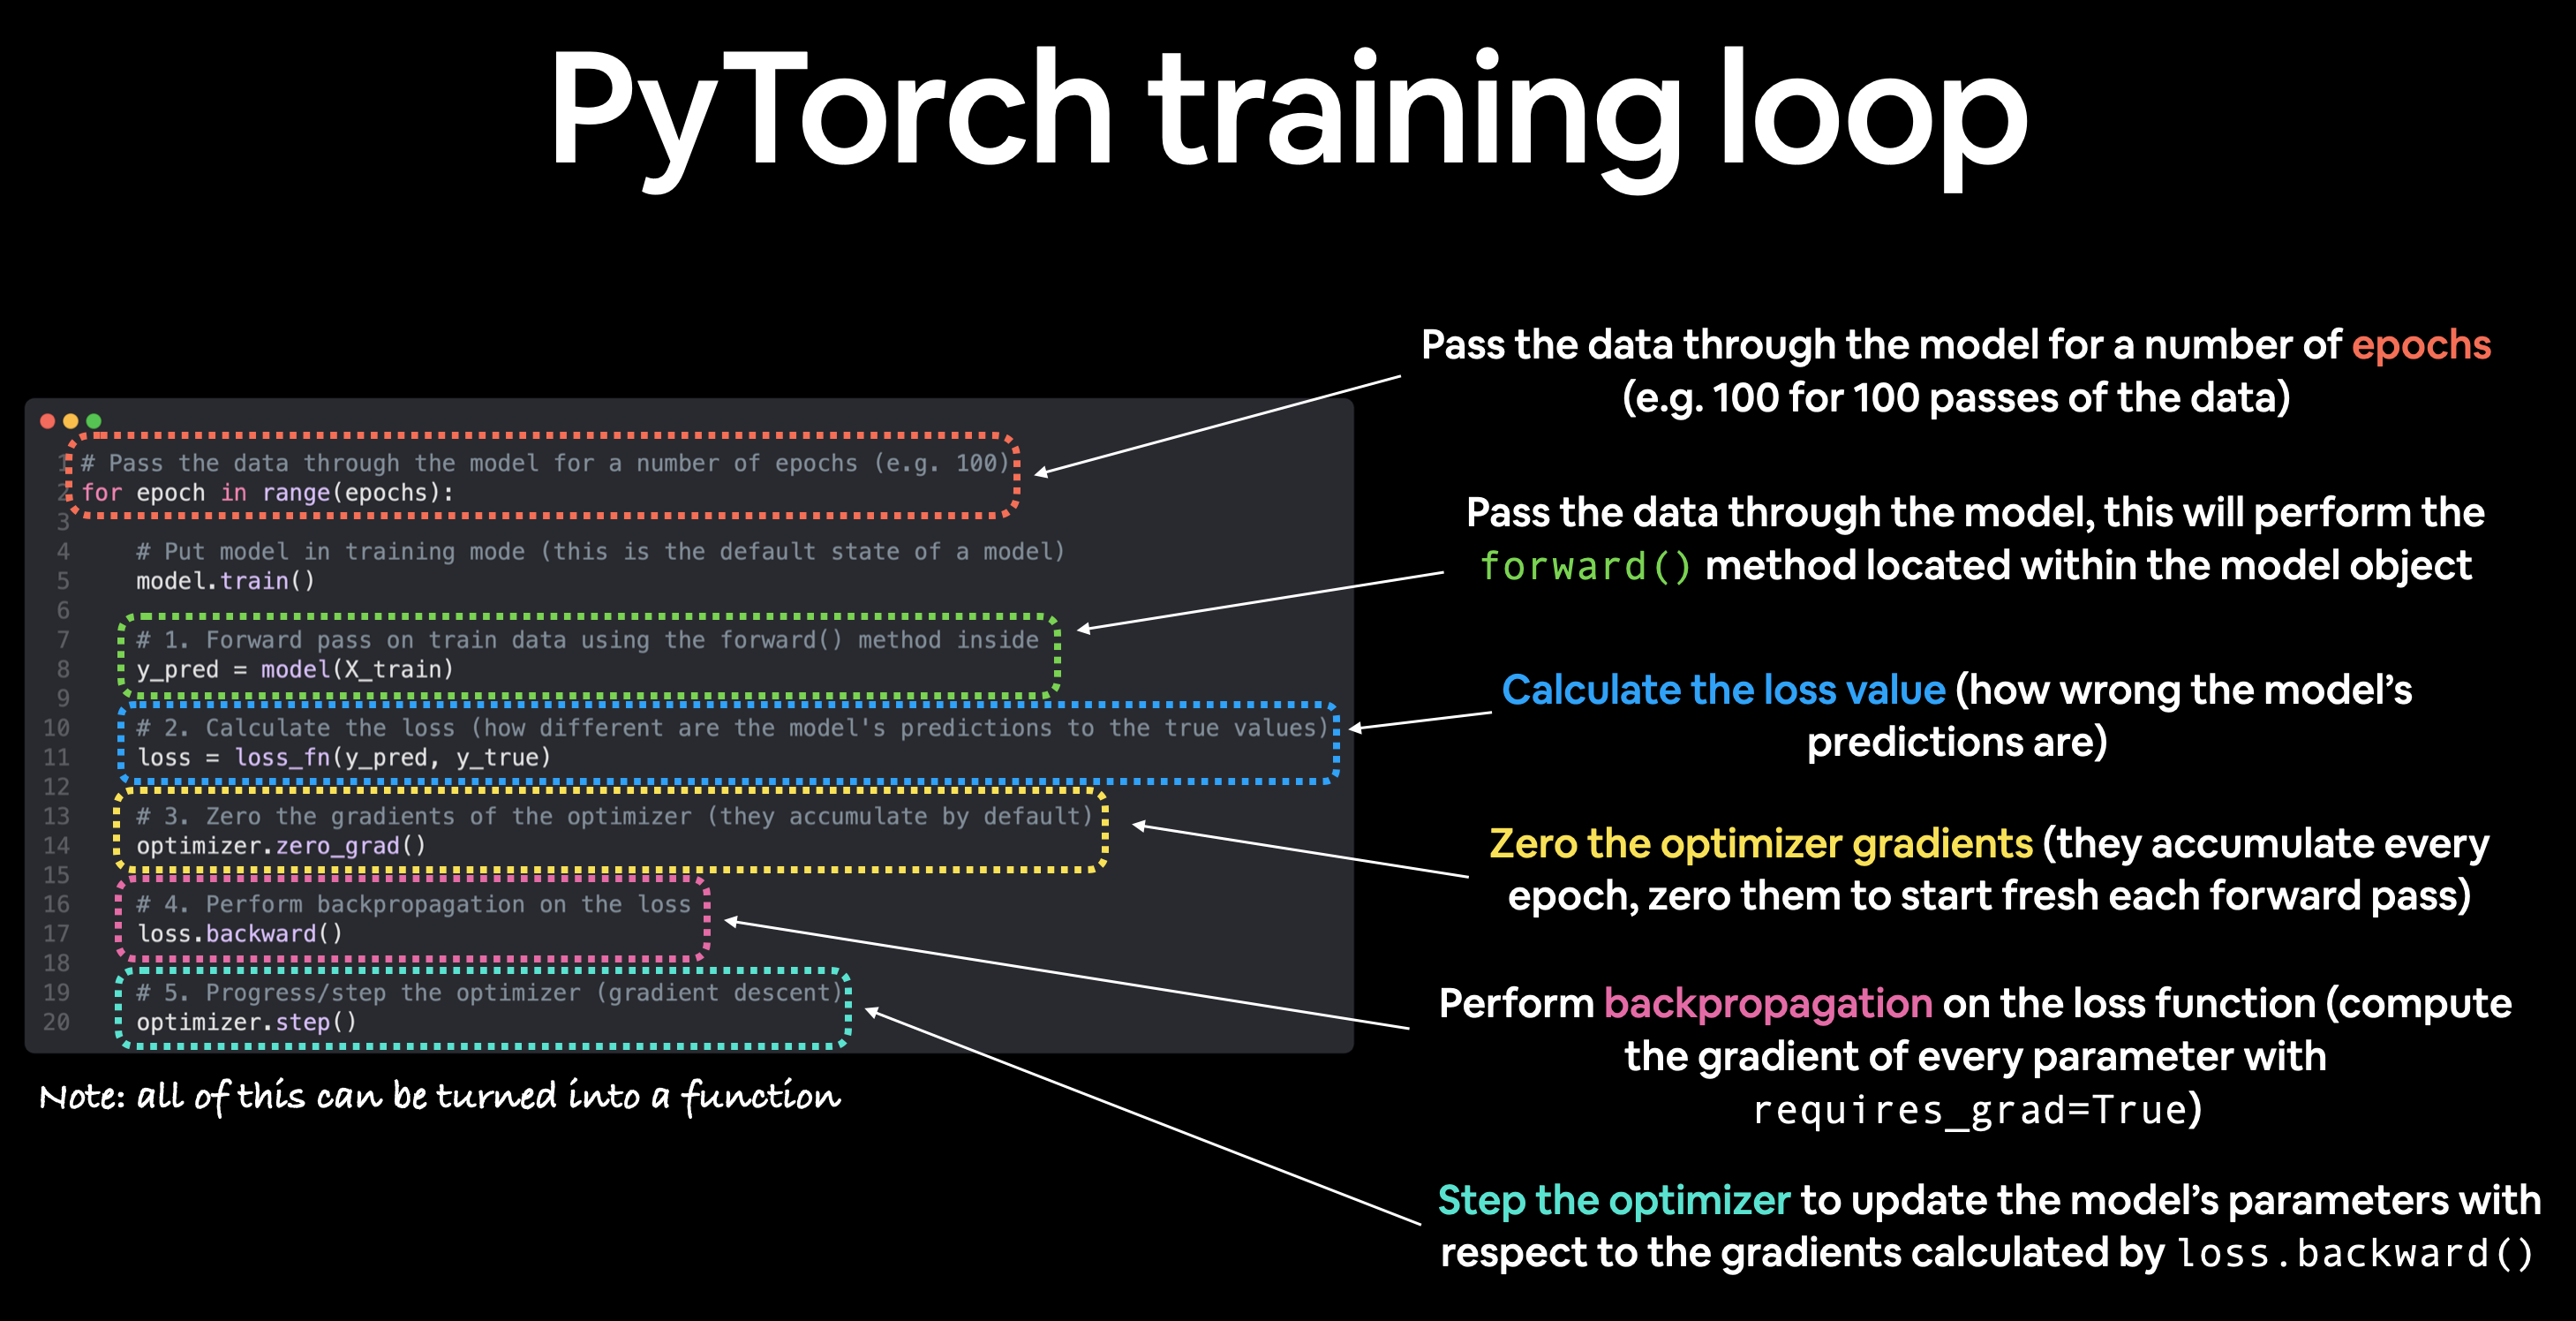




In [78]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

# for epochs in a range
for epoch in range(epochs):

  # It's train time
  model_0.train()

  # do the forward pass
  y_pred = model_0(X_train)

  # calculate the loss
  loss = loss_fn(y_pred, y_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # optimizer step, step, step
  optimizer.step()

  # It's test time
  model_0.eval()

  with torch.inference_mode():

    # do the forward pass
    test_pred = model_0(X_test)

    # calculate the loss
    test_loss = loss_fn(test_pred, y_test)

    # print out what's happening
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      # If we don't detach we can't plot.
      # The following error shows up
      # Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
Epoch: 10 | Train Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
Epoch: 20 | Train Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
Epoch: 30 | Train Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
Epoch: 40 | Train Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
Epoch: 50 | Train Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
Epoch: 60 | Train Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
Epoch: 70 | Train Loss: 0.03476089984178543 | Test Loss: 0.0805937647819519
Epoch: 80 | Train Loss: 0.03132382780313492 | Test Loss: 0.07232122868299484
Epoch: 90 | Train Loss: 0.02788739837706089 | Test Loss: 0.06473556160926819


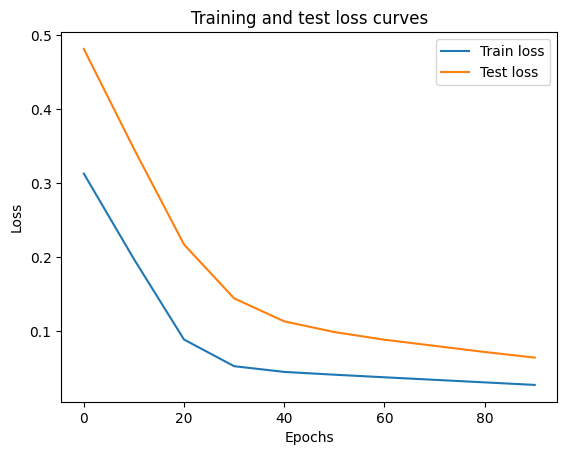

In [79]:
# plot everything !

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

The model's internal parameters are updated to better reflect the underlying patterns in the data.

We can inspect our model to see how close our model gets to the original values we set for weights and biases.

In [80]:
print(model_0.state_dict())

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])


In [81]:
print(f"original weights: {weight}")
print(f"original bias: {bias}")

original weights: 0.7
original bias: 0.3


# Make Predictions

1. Set the model in evaluation mode (model.eval()).
2. Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only)

In [82]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)

y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

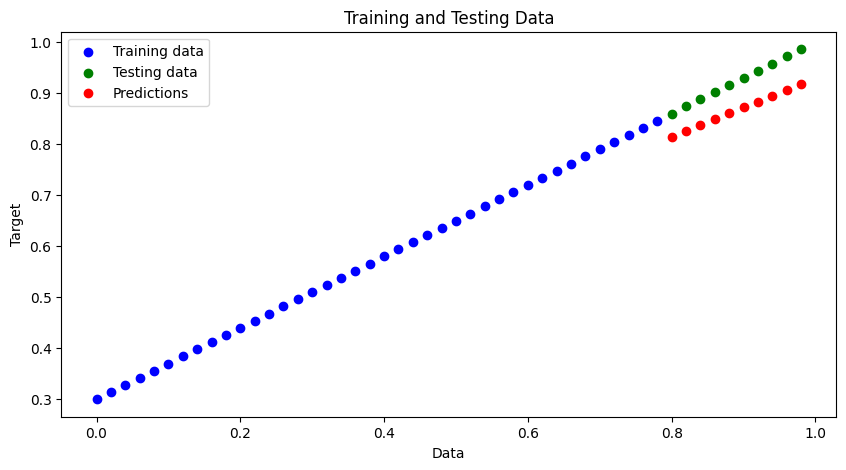

In [83]:
plot_prediction(predictions = y_preds)

# Saving and Loading a Pytorch Model

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's state_dict().

1. We'll create a directory for saving models to called models using Python's pathlib module.
2. We'll create a file path to save the model to.
3. We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.

We can load a saved model using the torch.nn.Module.load_state_dict(torch.load(f))

In [84]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [85]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [86]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [87]:
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [88]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it together

In [89]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [91]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

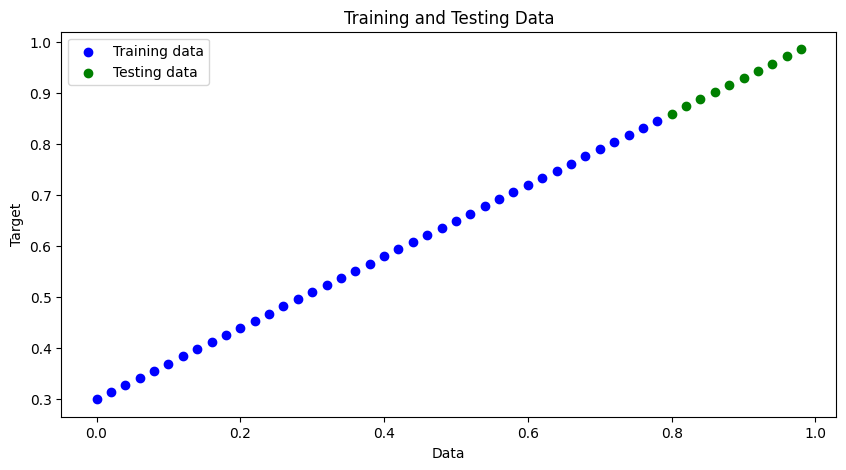

In [92]:
plot_prediction(X_train, y_train, X_test, y_test)

In [93]:
class LinearRegressionV2(nn.Module):

  def __init__(self):

    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    return self.linear_layer(x)

**in_features** is the number of dimensions your input data has and **out_features** is the number of dimensions you'd like it to be output to.

In our case, both of these are 1 since our data has **1 input feature (X) per label (y)**

In [94]:
torch.manual_seed(42)

model_1 = LinearRegressionV2()

model_1, model_1.state_dict()

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [95]:
# check model device

next(model_1.parameters()).device

device(type='cpu')

In [96]:
# change device to gpu if available

model_1.to(device)

next(model_1.parameters()).device

device(type='cpu')

In [97]:
# training

# loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [99]:
# training and testing loop

torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

  model_1.train()

  y_pred = model_1(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing time !

  model_1.eval()

  with torch.inference_mode():

    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 100 | Train Loss: 0.006215679459273815 | Test Loss: 0.014086711220443249
Epoch: 200 | Train Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 300 | Train Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 400 | Train Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 500 | Train Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 600 | Train Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 700 | Train Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 800 | Train Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 900 | Train Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904


In [100]:
# making predictions

model_1.eval()

with torch.inference_mode():

  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

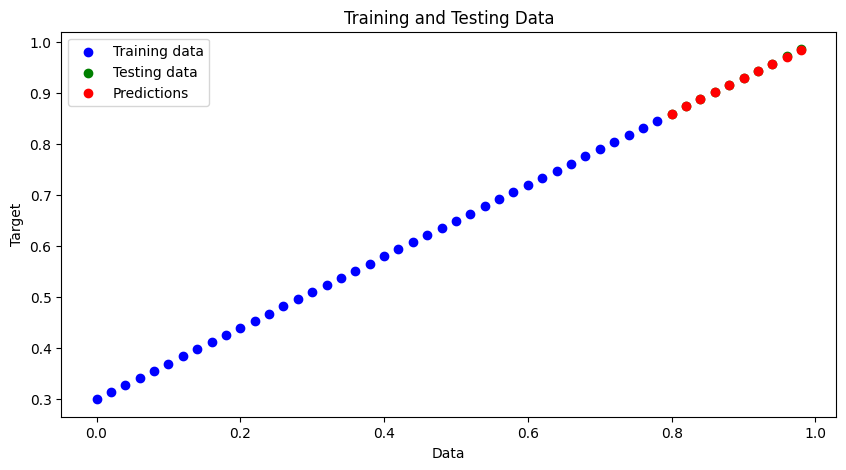

In [102]:
plot_prediction(predictions = y_preds.cpu())